# Steady-state Ligand-Receptor inference

`liana` provides different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its most basic form with toy data.

We also refer users to the [Cell-cell communication chapter](https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html) in the [best-practices guide from Theis lab](https://www.nature.com/articles/s41576-023-00586-w). There we provide an overview of the common limitations and assumptions in CCC inference from (dissociated single-cell) transcriptomics data.

## Loading Packages

In [1]:
# import liana
import liana as li
# needed for visualization and toy data
import scanpy as sc

## Loading toy data

In the most general case, `liana`'s ligand-receptor methods use `anndata` objects with processed single-cell transcriptomics data, with pre-defined cell labels (identities), to infer ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

In [2]:
adata = sc.datasets.pbmc68k_reduced()

The example single-cell data consists processed data with PBMCs cell types

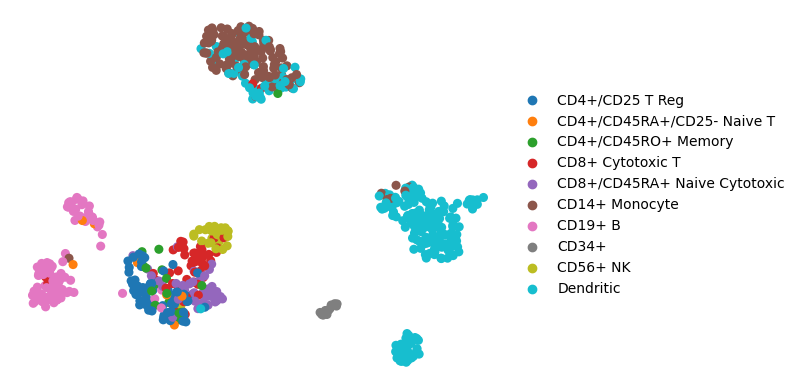

In [3]:
sc.pl.umap(adata, color='bulk_labels', title='', frameon=False)

## Background

`liana` typically works with the log1p-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

In [4]:
adata.raw.X

<700x765 sparse matrix of type '<class 'numpy.float32'>'
	with 174400 stored elements in Compressed Sparse Row format>

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

### Methods

In [5]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


Each method infers relevant ligand-receptor interactions relying on different assumptions and each method returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

<div class="alert alert-info">

**Note**
    
<h4> Method Class</h4>
    
Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

</div>


For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

In [6]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

In [7]:
?rank_aggregate.__call__

Signature:
rank_aggregate.__call__(
    adata: 'an.AnnData | MuData',
    groupby: 'str',
    resource_name: 'str' = 'consensus',
    expr_prop: 'float' = 0.1,
    min_cells: 'int' = 5,
    groupby_pairs: 'Optional[DataFrame]' = None,
    base: 'float' = 2.718281828459045,
    aggregate_method: 'str' = 'rra',
    consensus_opts: 'Optional[list]' = None,
    return_all_lrs: 'bool' = False,
    key_added: 'str' = 'liana_res',
    use_raw: 'Optional[bool]' = True,
    layer: 'Optional[str]' = None,
    de_method: 'str' = 't-test',
    n_perms: 'int' = 1000,
    seed: 'int' = 1337,
    n_jobs: 'int' = 1,
    resource: 'Optional[DataFrame]' = None,
    interactions: 'Optional[list]' = None,
    mdata_kwargs: 'dict' = {},
    inplace: 'bool' = True,
    verbose: 'Optional[bool]' = False,
)
Docstring:
Get an aggregate of ligand-receptor scores from multiple methods.

Parameters
----------
adata
    Annotated data object.
groupby
    Key to be used for grouping.
resource_name
    Name of the r

or alternatively:

In [8]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


## By default, LIANA+ uses **human gene symbols**. See the documentation and the [Prior Knowledge vignette](https://liana-py.readthedocs.io/en/latest/notebooks/prior_knowledge.html) for details and instructions for homology conversion.


## Example Run

### Individual Methods

In [9]:
# import all individual methods
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

<div class="alert alert-info">

**Note**

LIANA will by default use the `.raw` attribute of AnnData. If you wish to use .X set `use_raw` to `False`, or specify a `layer`.

LIANA will also by default use the 'consensus' resource to infer ligand-receptor interactions. 
This resource was created as a consensus from the resources literature-curated resources in OmniPath, and uses **human gene symbols**.

For different species, we provide 'mouseconsensus', for any other species you can provide your own resource, or translate LIANA's resources as shown [here](https://liana-py.readthedocs.io/en/latest/notebooks/prior_knowledge.html#Homology-Mapping).

If you wish to use a different resource, please specify it via the `resource_name` parameter for internal resources, or provide an external one via `resource` or `interactions`.
    
</div>  

In [10]:
# run cellphonedb
cellphonedb(adata,
            groupby='bulk_labels', 
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='consensus',
            expr_prop=0.1,
            verbose=True, key_added='cpdb_res')

Using resource `consensus`.
Using `.raw`!
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 43 features


100%|██████████| 1000/1000 [00:01<00:00, 822.60it/s]


By default, liana will be run **inplace** and results will be assigned to `adata.uns['liana_res']`.
Note that the high proportion of missing entities here is expected, as we are working on the reduced dimensions data.

In [11]:
# by default, liana's output is saved in place:
adata.uns['cpdb_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
482,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.612842,0.421053,Dendritic,CD4+/CD45RO+ Memory,2.575263,0.0
321,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.596125,0.500000,Dendritic,CD4+/CD45RA+/CD25- Naive T,2.566905,0.0
989,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.483977,0.302326,Dendritic,CD14+ Monocyte,2.510830,0.0
651,HLA-DRA,HLA-DRA,4.537684,0.995833,LAG3,LAG3,0.399500,0.240741,Dendritic,CD8+ Cytotoxic T,2.468592,0.0
1392,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.373671,0.270833,Dendritic,Dendritic,2.455678,0.0


Here, we see that stats are provided for both ligand and receptor entities, more specifically: `ligand` and `receptor` are the two entities that potentially interact. As a reminder, CCC events are not limited to secreted signalling, but we refer to them as `ligand` and `receptor` for simplicity.

Also, in the case of heteromeric complexes, the `ligand` and `receptor` columns represent the subunit with minimum expression, while `*_complex` corresponds to the actual complex, with subunits being separated by `_`.

- `source` and `target` columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity. 

  By default, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive,
  under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction **magnitude**

- `cellphone_pvals`: permutation-based p-values, as a measure of interaction **specificity**

<div class="alert alert-info">

**Note**
    
`ligand`, `receptor`, `source`, and `target` columns are returned by every ligand-receptor method, while the rest of the columns can vary across the ligand-receptor methods, as each method infers relies on different assumptions and scoring functions, and hence each returns different ligand-receptor scores. Nevertheless, typically most methods use a pair of scoring functions - where one often corresponds to the **magnitude** (strength) of interaction and the other reflects how **specificity** of a given interaction to a pair cell identities.
    
</div>

#### Dotplot

We can now visualize the results that we just obtained.

LIANA provides some basic, but flexible plotting functionalities. Here, we will generate a dotplot of relevant ligand-receptor interactions.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


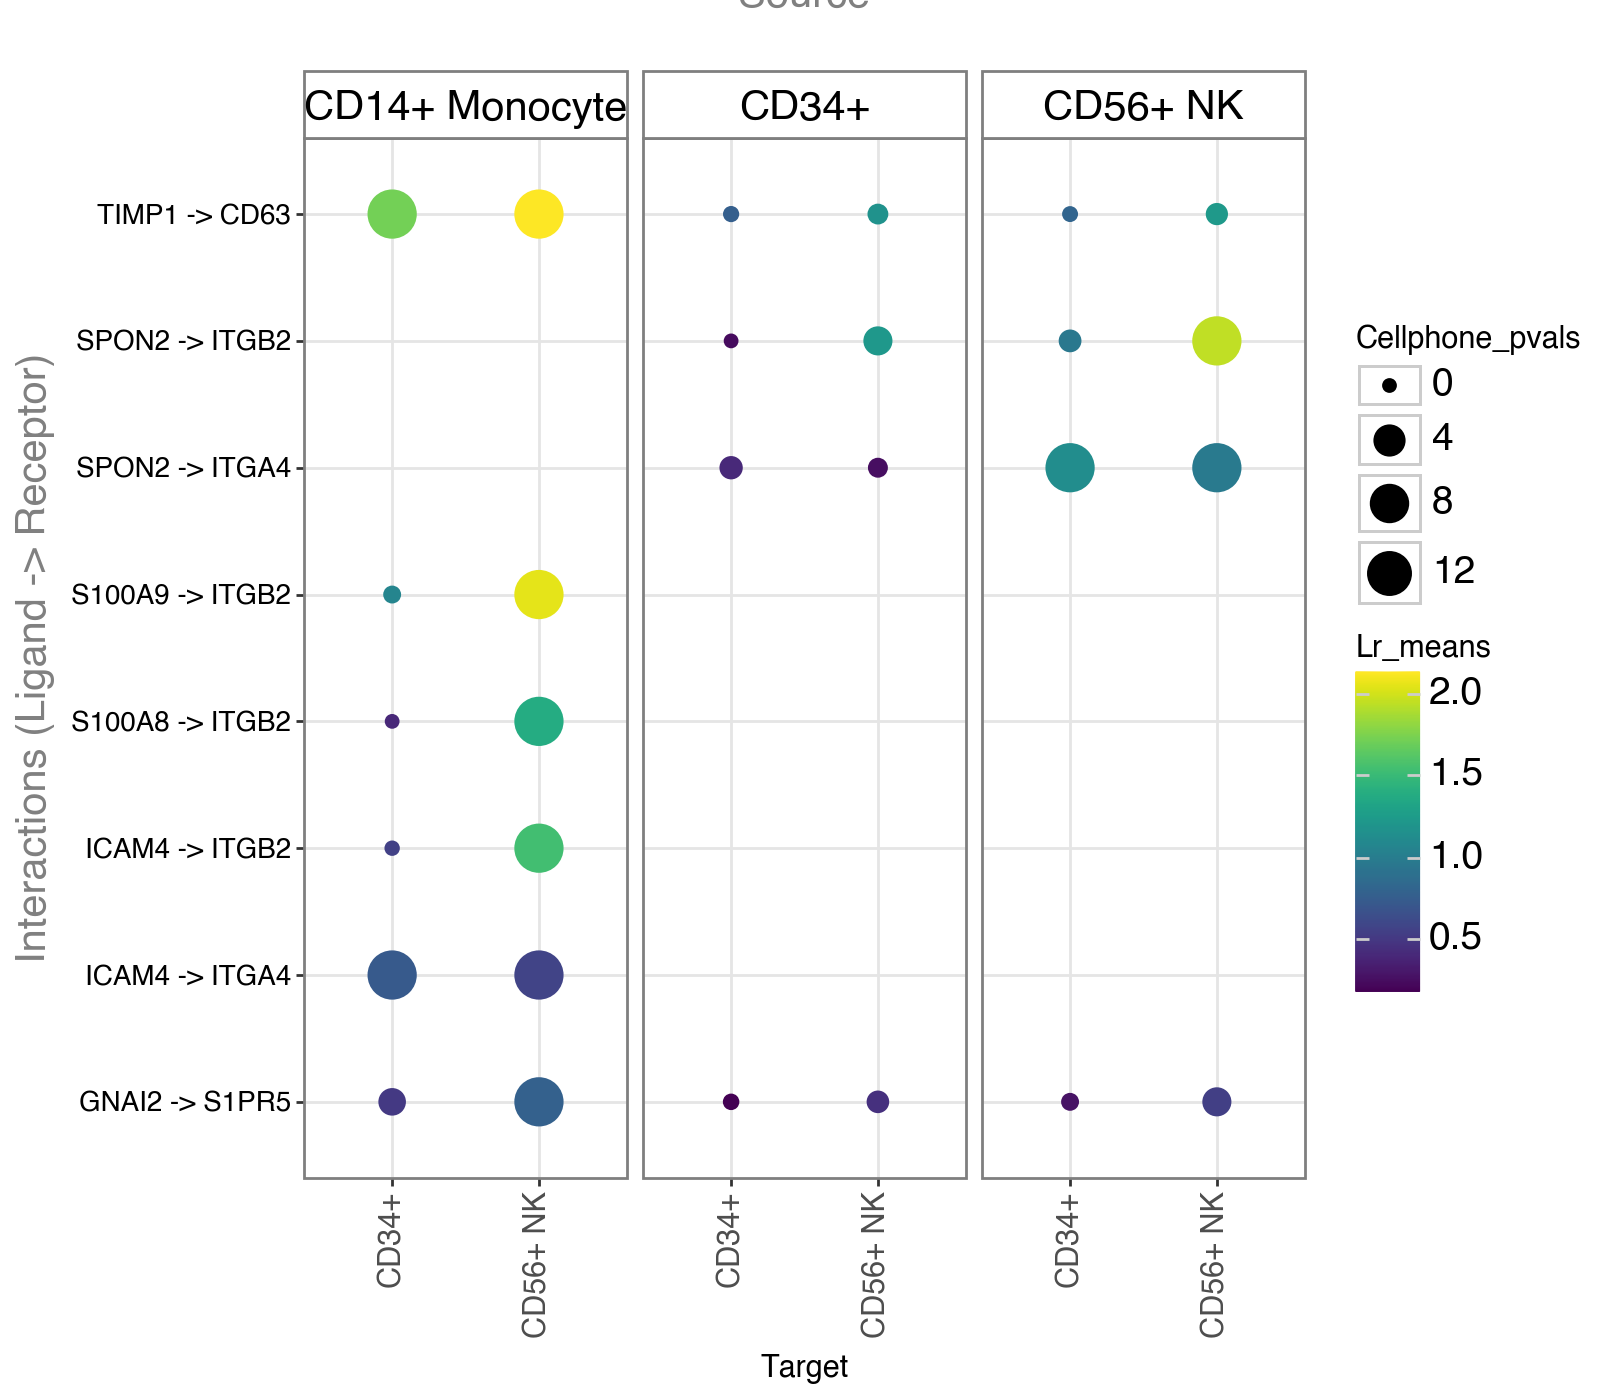

In [12]:
li.pl.dotplot(adata = adata, 
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
              uns_key='cpdb_res' # uns_key to use, default is 'liana_res' 
             )

<div class="alert alert-info">
   
**Note**
    
Missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`. One can change this threshold by setting `expr_prop` to a different value. Alternatively, setting `return_all_lrs` to `True` will return all ligand-receptor interactions, regardless of expression.
</div>

#### Tileplot

While dotplots are useful to visualize the most relevant interactions, LIANA's tileplots are more useful when visualizing the statistics of ligands and receptors, individually.

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/plotting/_common.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


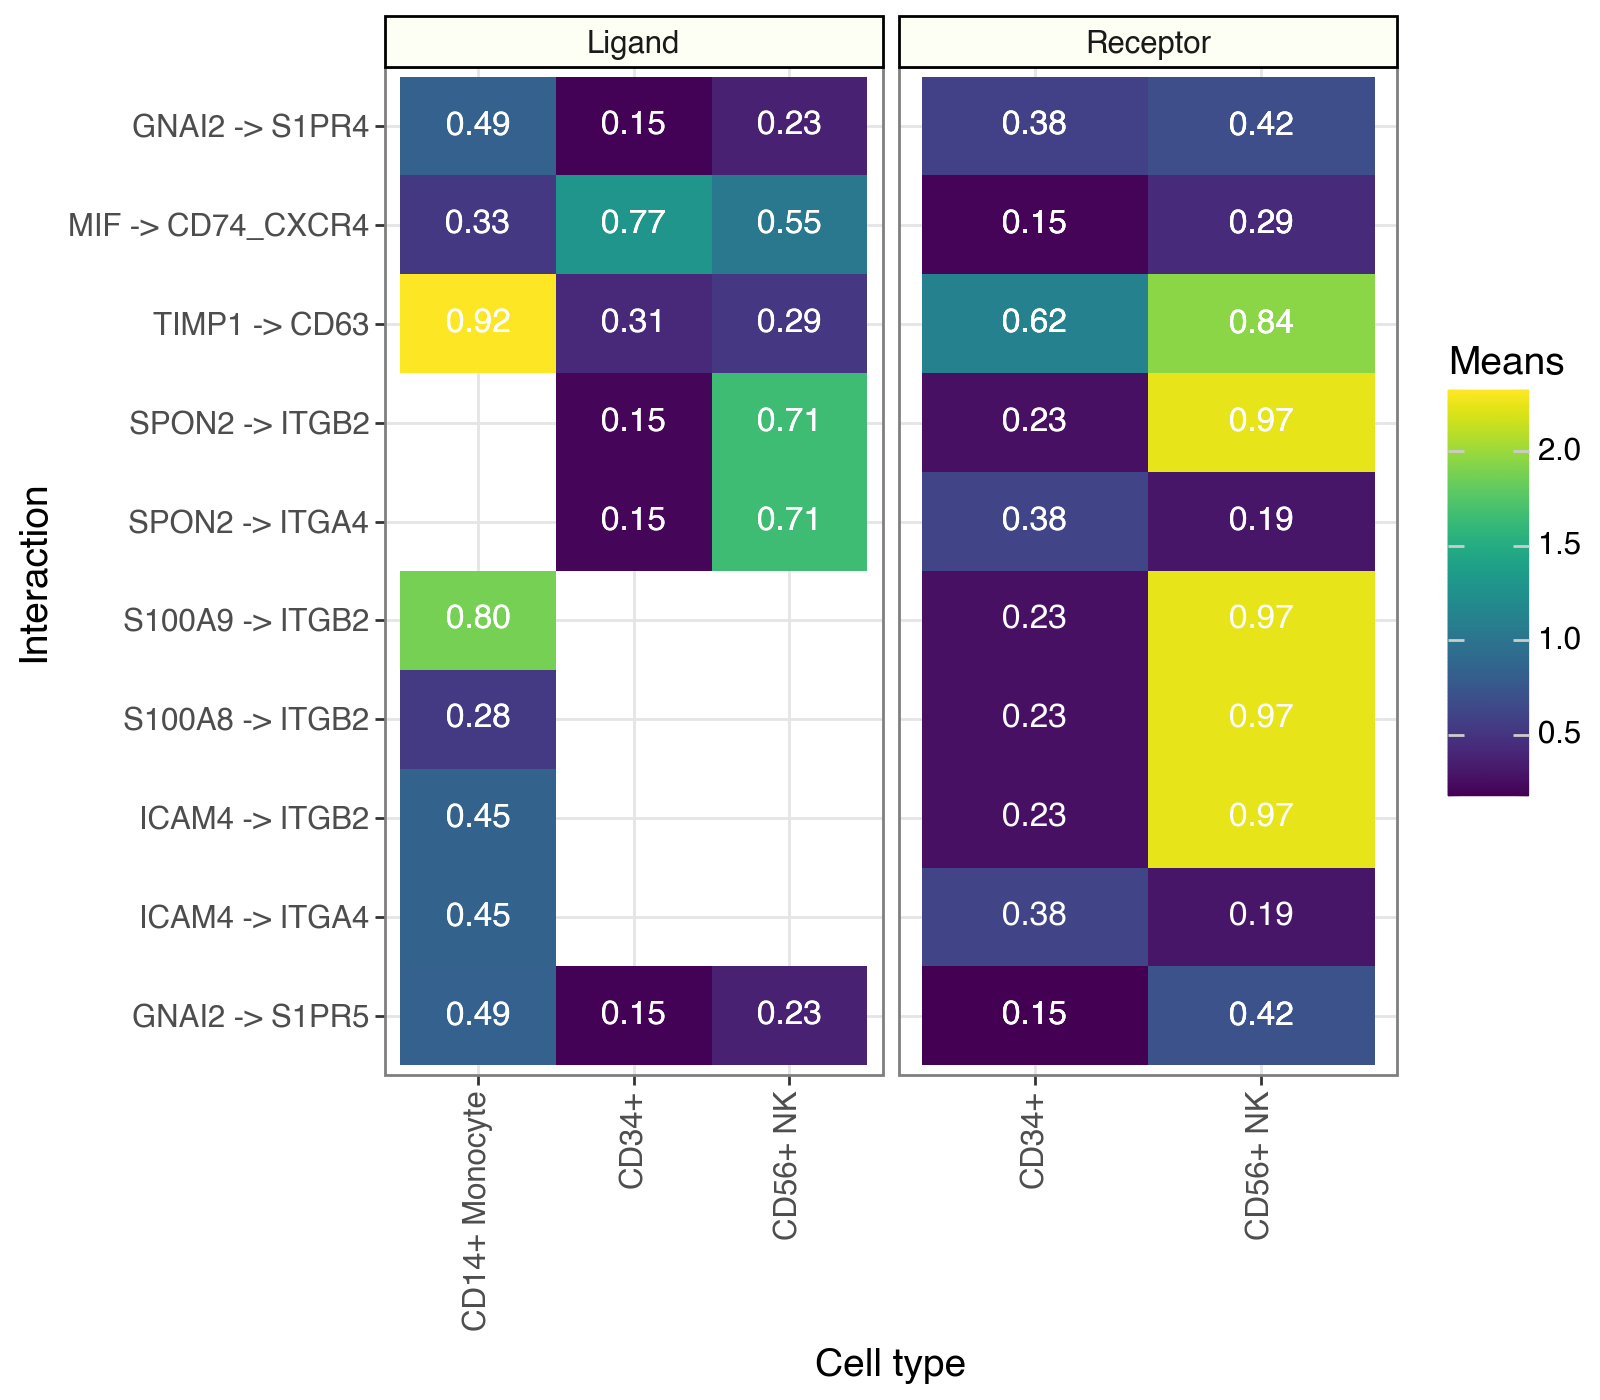

In [13]:
my_plot = li.pl.tileplot(adata = adata, 
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=10, 
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                         target_labels=['CD34+', 'CD56+ NK'],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

### Rank Aggregate
In addition to the individual methods, LIANA also provides a consensus that integrates the predictions of individual methods.
This is done by ranking and aggregating ([RRA](https://academic.oup.com/bioinformatics/article-abstract/28/4/573/213339)) the ligand-receptor interaction predictions from all methods.

In [14]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, 
                     groupby='bulk_labels',
                     resource_name='consensus',
                     expr_prop=0.1,
                     verbose=True)

Using resource `consensus`.
Using `.raw`!
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.94 of entities in the resource are missing from the data.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Generating ligand-receptor stats for 700 samples and 43 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 977.49it/s]

Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [15]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
1209,Dendritic,CD4+/CD45RO+ Memory,HLA-DRA,CD4,2.575263,0.0,2.780884,0.723815,1.431302,0.065077,0.736772,0.001137,0.000653
1188,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRA,CD4,2.566905,0.0,2.705027,0.709428,1.332656,0.063302,0.734081,0.001137,0.000911
1210,Dendritic,CD4+/CD45RO+ Memory,HLA-DRB1,CD4,2.415010,0.0,2.584465,0.712731,1.331341,0.060203,0.729607,0.001137,0.001211
1205,Dendritic,CD4+/CD45RO+ Memory,HLA-DPB1,CD4,2.367473,0.0,2.526199,0.731297,1.447014,0.068953,0.727352,0.001137,0.001377
1189,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRB1,CD4,2.406652,0.0,2.513965,0.698344,1.232695,0.058561,0.726870,0.001137,0.001741


In [16]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


The remainder of the columns in this dataframe are those coming from each of the methods included in the `rank_aggregate` - i.e. see the `show_methods` to map methods to scores.

#### Dotplot

We will now plot the most 'relevant' interactions ordered to the `magnitude_rank` results from aggregated_rank.

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/plotting/_common.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


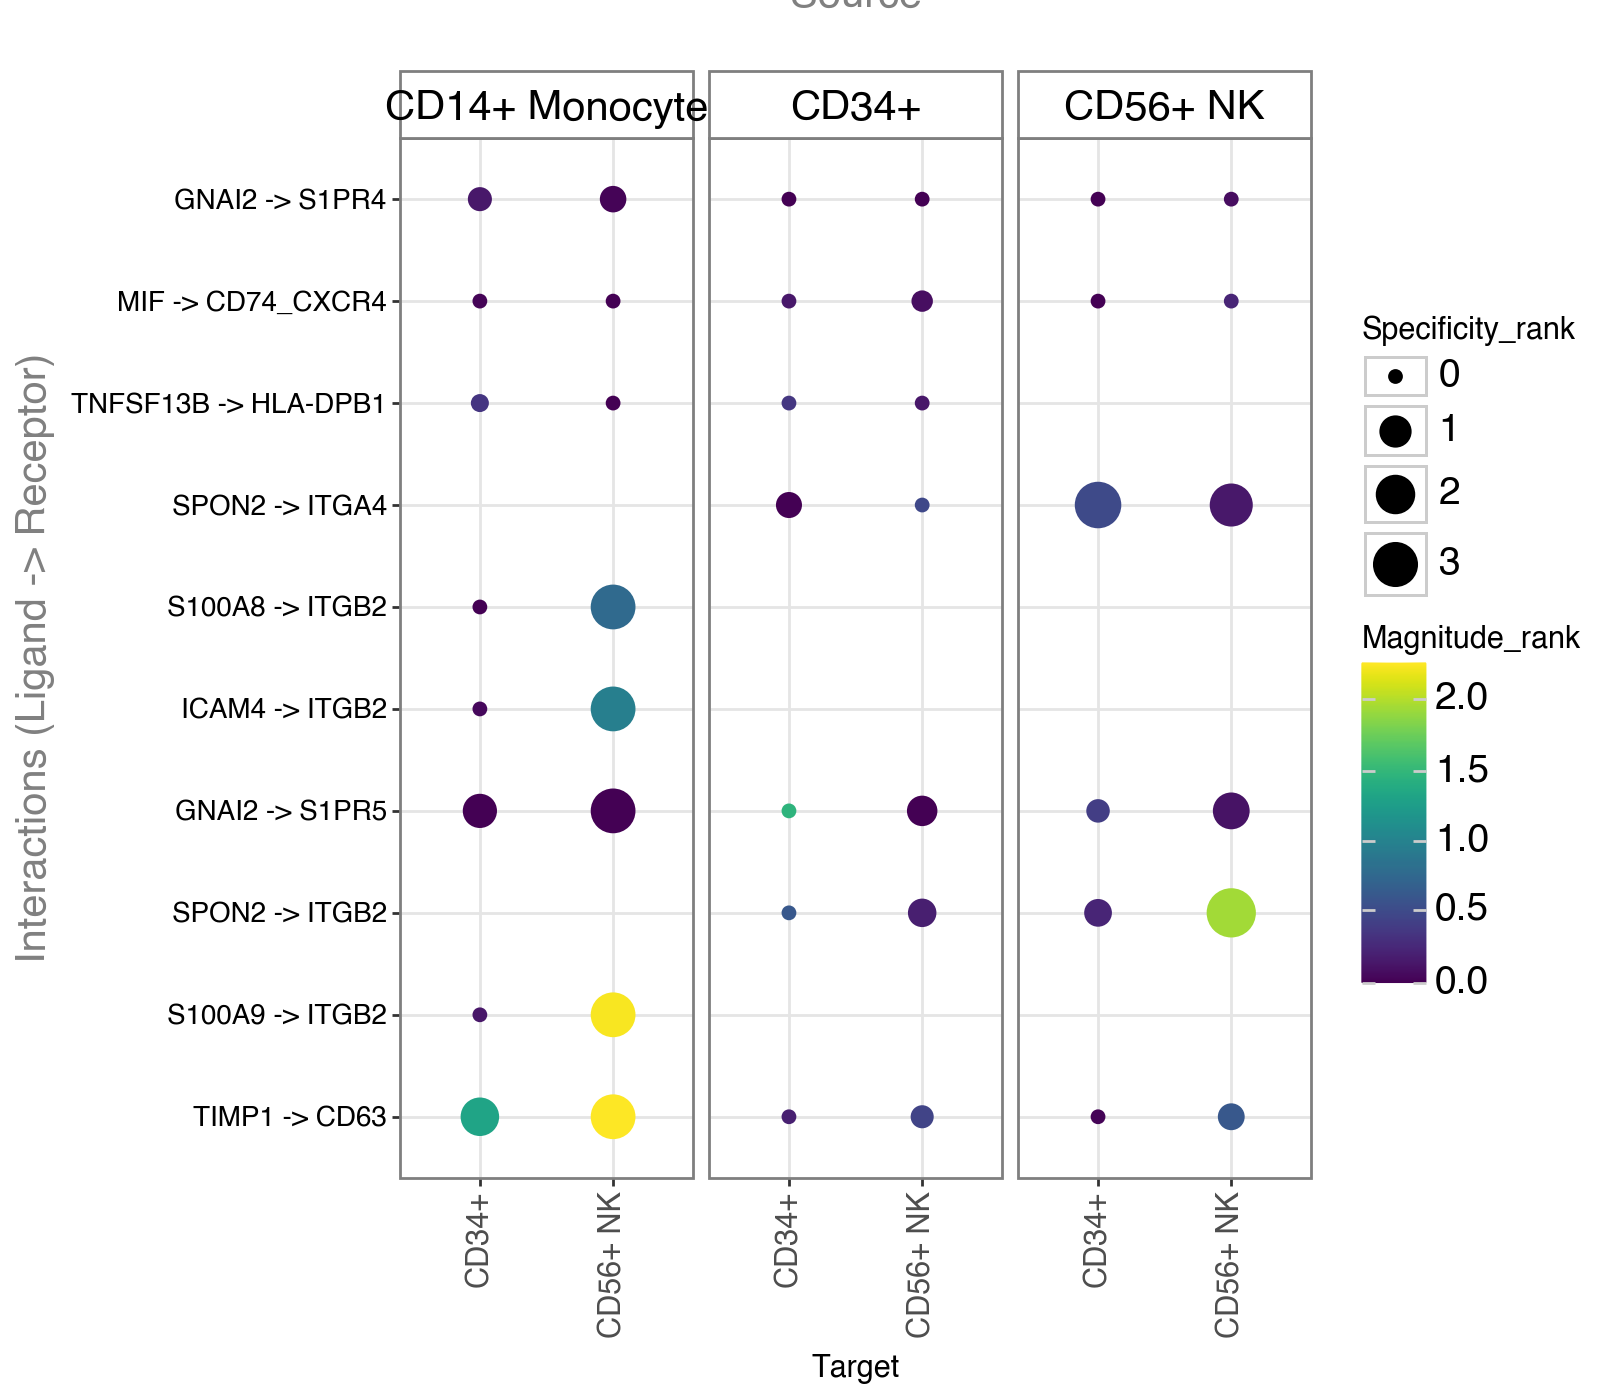

In [17]:
li.pl.dotplot(adata = adata, 
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              top_n=10, 
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

Similarly, we can also treat the ranks provided by RRA as a probability distribution to which we can `filter` interactions
according to how robustly and highly ranked they are across the different methods.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


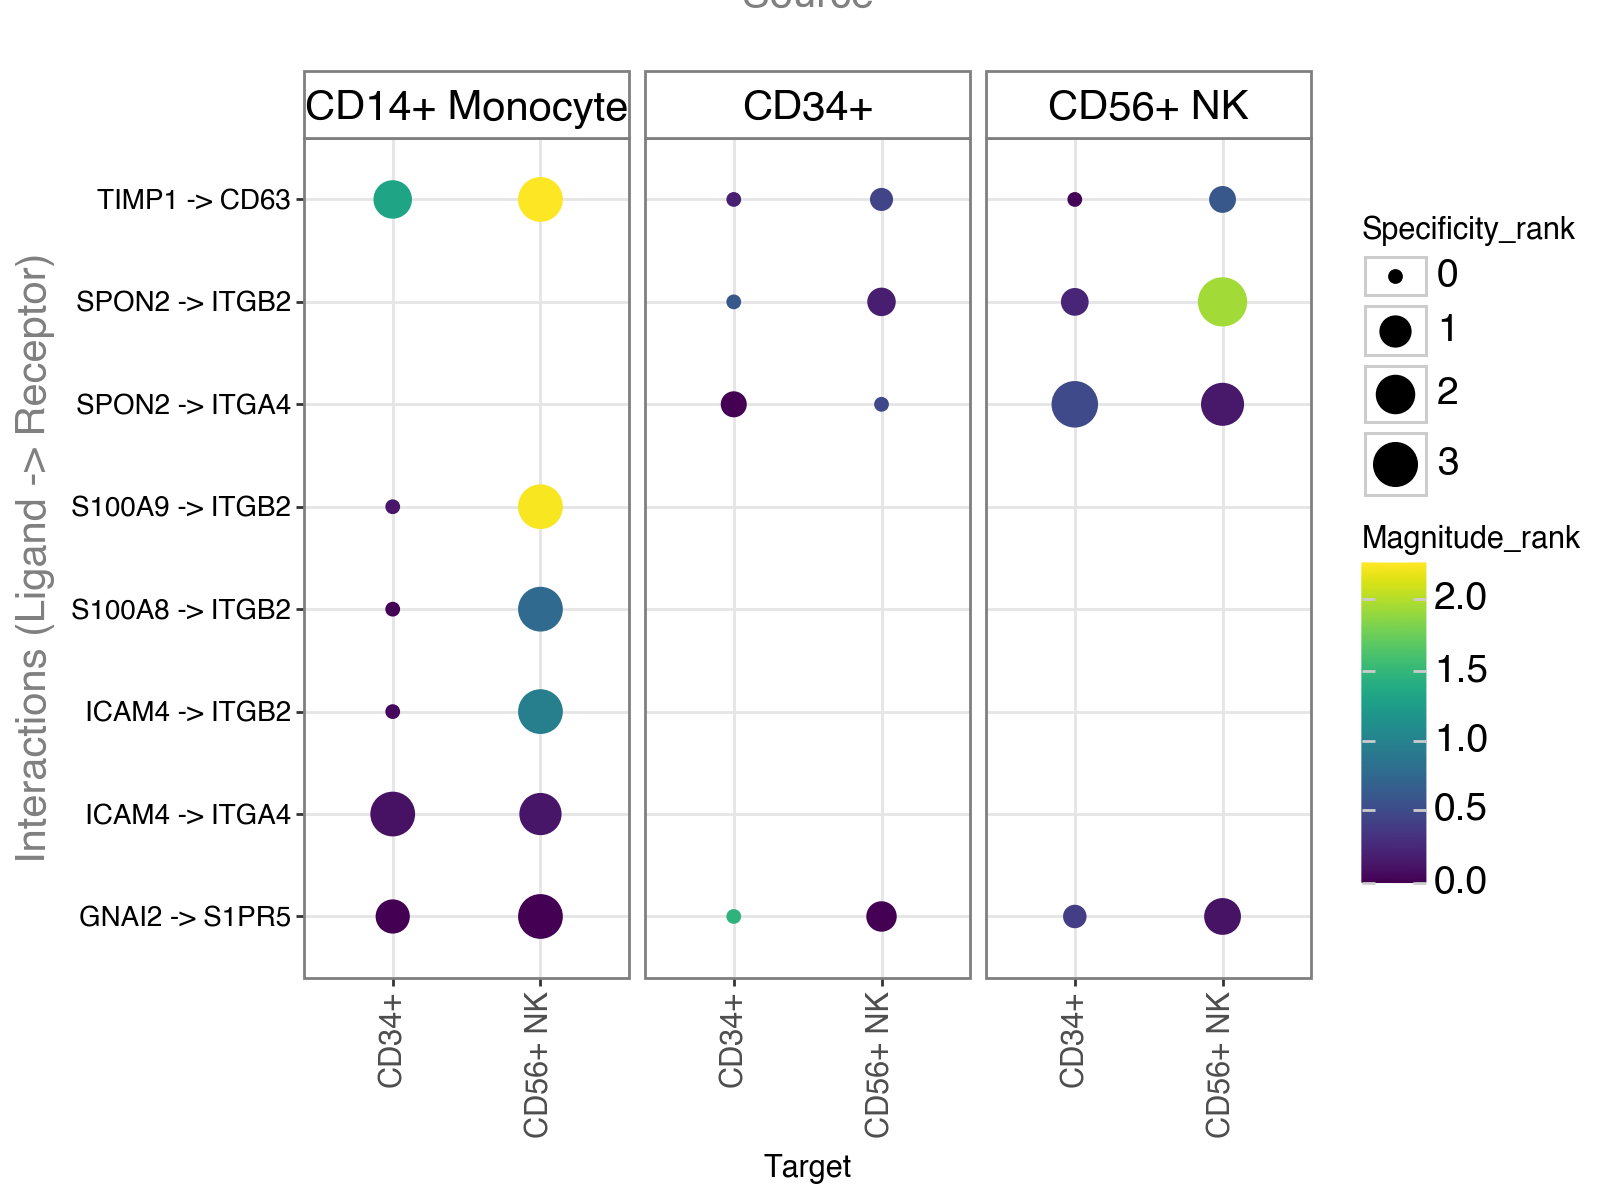

In [18]:
my_plot = li.pl.dotplot(adata = adata, 
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                        target_labels=['CD34+', 'CD56+ NK'],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.01,
                       )
my_plot

Save the plot to a file:

In [19]:
my_plot.save('dotplot.pdf')

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: dotplot.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


#### Customizing LIANA's Plots

Finally, the plots in liana are built with `plotnine` and their aesthetics can be easily modified. For example:

In [20]:
# we import plotnine
import plotnine as p9

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


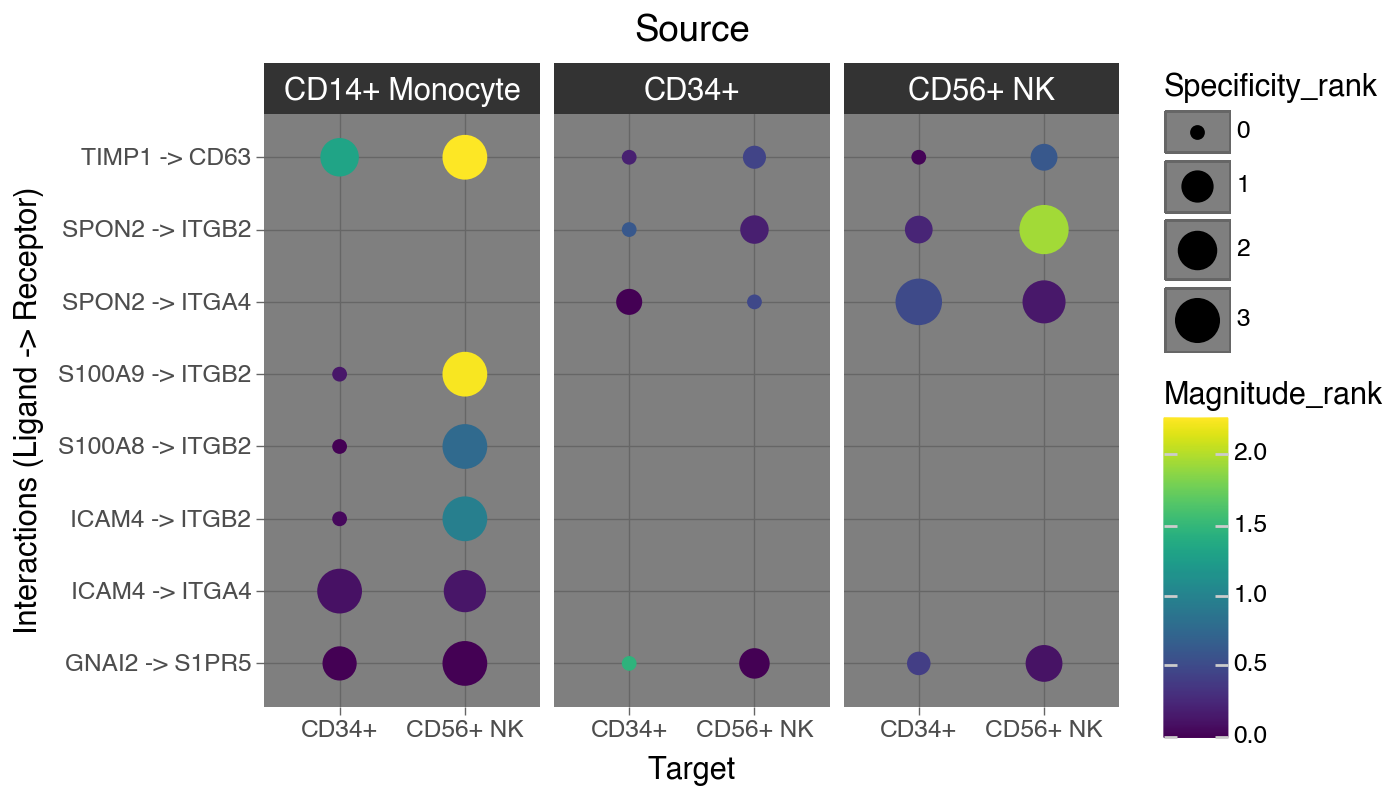

In [21]:
(my_plot +
 # change theme
 p9.theme_dark() +
 # modify theme
 p9.theme(
     # adjust facet size
     strip_text=p9.element_text(size=11),
     figure_size=(7, 4)
 )
)

For more plot modification options  we refer the user to `plotnine`'s tutorials
and to the following link for a quick intro: 
https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html.

#### Circle Plot

While the majority of liana's plots are in plotnine, thanks to @WeipengMo, we also provide a circle plot (drawn in networkx):

<Axes: >

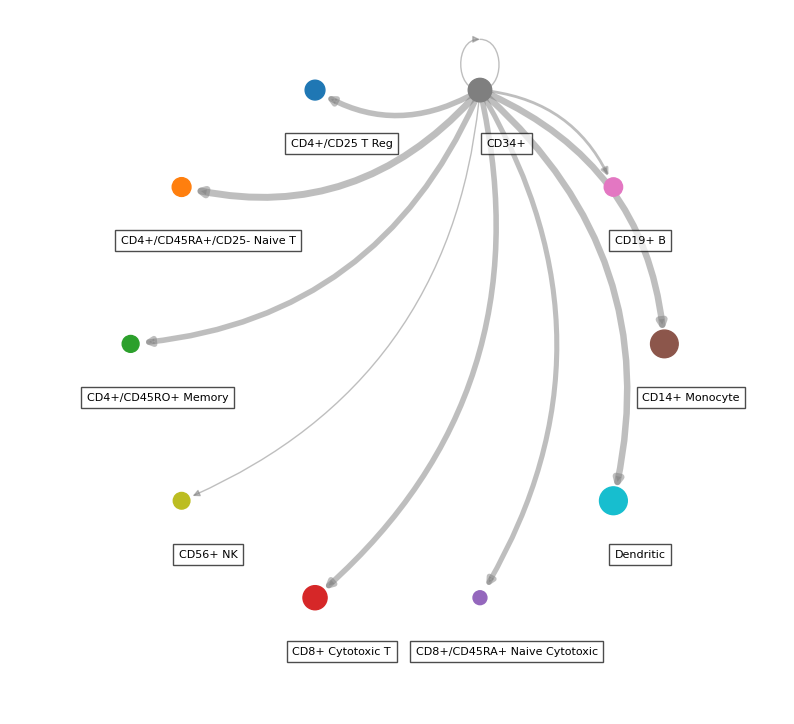

In [22]:
li.pl.circle_plot(adata,
                  groupby='bulk_labels',
                  score_key='magnitude_rank',
                  inverse_score=True,
                  source_labels='CD34+',
                  filter_fun=lambda x: x['specificity_rank'] <= 0.05,
                  pivot_mode='counts', # NOTE: this will simply count the interactions, 'mean' is also available
                  figure_size=(10, 10),
                  )

## Customizing LIANA's rank aggregate

LIANA's rank aggregate is also customizable, and the user can choose to include only a subset of the methods.

For example, let's generate a consensus with geometric mean and logfc methods only:

In [23]:
methods = [logfc, geometric_mean]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [24]:
new_rank_aggregate(adata,
                   groupby='bulk_labels',
                   expr_prop=0.1, 
                   verbose=True,
                   # Note that with this option, we don't perform permutations
                   # and hence we exclude the p-value for geometric_mean, as well as specificity_rank
                   n_perms=None,
                   use_raw=True,
                   )

Using resource `consensus`.
Using `.raw`!
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.94 of entities in the resource are missing from the data.
/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:272: ImplicitModificationWarning: Setting element `.layers['normcounts']` of view, initializing view as actual.


Generating ligand-receptor stats for 700 samples and 43 features
Assuming that counts were `natural` log-normalized!
Running log2FC
Running Geometric Mean


Check the results

In [25]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_logfc,lr_gmeans,magnitude_rank
110,CD14+ Monocyte,CD56+ NK,TIMP1,CD63,1.435273,2.126363,0.000776
109,CD14+ Monocyte,CD56+ NK,S100A9,ITGB2,1.069681,2.048953,0.001553
20,CD14+ Monocyte,CD14+ Monocyte,S100A9,ITGB2,1.069747,1.979753,0.002329
838,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.860055,1.926317,0.003106
782,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.860121,1.861258,0.003882


## Method Details
(Rendered version of **Supplementary Table 3** from the manuscript)

| Method                         | Magnitude                                                                                      | Specificity                                                                                  |
|--------------------------------|------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| [CellPhoneDBv2](https://www.nature.com/articles/s41596-020-0292-x)                  | $$LRmean_{k,ij} = \frac{L_{C_{i}} + R_{C_{j}}}{2}$$                                             | See ρ                                                                                        |
| Geometric Mean                 | $$LRgeometric.mean_{k,ij} = \sqrt{L_{C_{i}} \cdot R_{C_{j}}}$$                                 | See ρ                                                                                        |
| [CellChat's](https://www.nature.com/articles/s41467-021-21246-9) LR probabilities †      | $$LRprob_{k,ij} = \frac{L^*_{C_{i}} \cdot R^*_{C_{j}}}{Kh + L^*_{C_{i}} \cdot R^*_{C_{j}}}$$ where Kh is a normalizing parameter (set to 0.5 by default) and L* & R* are aggregated using Tuckey's Trimean function (See below). | See ρ                                                                                        |
| [SingleCellSignalR](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7261168/)              | $$LRscore_{k,ij} = \frac{\sqrt{L_{C_{i}} R_{C_{j}}}}{\sqrt{L_{C_{i}} R_{C_{j}}} + \mu}$$ where $\mu$ is the mean of the expression matrix M     | -                                                                                            |
| [NATMI](https://www.nature.com/articles/s41467-020-18873-z)                          | $$LRproduct_{k,ij} = L_{C_{i}} R_{C_{j}}$$                                                    | $$SpecificityWeight_{k,ij} = \frac{L_{C_{i}}}{\sum^{n} L_{C_{i}}} \cdot \frac{R_{C_{j}}}{\sum^{n} R_{C_{j}}}$$ |
| [Connectome](https://www.nature.com/articles/s41598-022-07959-x)                     | $$LRproduct_{k,ij} = L_{C_{i}} R_{C_{j}}$$                                                    | $$LRz.mean_{k,ij} = \frac{z_{L_{C_{i}}} + z_{R_{C_{j}}}}{2}$$   where z is the z-score of the expression matrix M|                                             |
| LogFC‡                         | -                                                                                              | $$LRlog2FC_{k,ij} = \frac{\text{Log2FC}_{C_i,L} + \text{Log2FC}_{C_j,R}}{2}$$                |
| [ScSeqComm](https://academic.oup.com/bioinformatics/article/38/7/1920/6511439) (intercellular scores only)   | $$LRinterscore_{k,ij} = \text{min}(P(L_{Ci}), P(R_{Cj}))$$ $$P(X) = \Phi\left(\frac{X - \mu}{\sigma / \sqrt{n}}\right)$$                              Where $\Phi$ is the CDF of a normal distribution, μ is the mean, σ is the standard deviation, and n is the number of observations | -                                                                                            |
| LIANA’s Consensus#             | Used flexibly to combine the Magnitude scores of the methods above. By default, uses all except the Geometric mean and CellChat, independently for magnitude and specificity scores. | Same as Magnitude Rank Aggregate but aggregates the specificity scores of different methods.                                                                                          |

**Shared Notation:**

- k is the k-th ligand-receptor interaction
- L - expression of ligand L; R - expression of receptor R; See Ѫ
- C - cell cluster
- i - cell group i
- j - cell group j
- M - a library-size normalised and log1p-transformed gene expression matrix
- X - normalised gene expression vector

**Permutations to calculate specificity (ρ):**

$$ p\text{-value}_{k,ij} = \frac{1}{P} \sum_{p=1}^{P} [fun_{permuted}(L^*_{C_{i}}, R^*_{C_{j}}) \geq fun_{observed}(L^*_{C_{i}}, R^*_{C_{j}})]$$

where P is the number of permutations, and L* and R* are ligand and receptor expressions aggregated by group (cluster) using fun; arithmetic mean for CellPhoneDB and Geometric Mean, and Tuckey’s TriMean for CellChat:

$$TriMean(X) = \frac{Q_{0.25}(X) + 2 \cdot Q_{0.5}(X) + Q_{0.75}(X)}{4}$$

**Consensus(#)**

First, a normalised rank matrix [0,1] is generated separately for magnitude and specificity as: 

$$r_{ij} = \frac{rank_{ij}}{\max(rank_i)} \quad (1 \leq i \leq m, 1 \leq j \leq n)$$

where m is the number of ranked score vectors, n is the length of each score vector (number of interactions), rankij is the rank of the j-th element (interaction) in the i-th score rank vector, and max(ranki) is the maximum rank in the i-th rank vector.

For each normalised rank vector r, we then ask how probable it is to obtain rnull(k)<= r(k), where rnull(k) is a rank vector generated under the null hypothesis. The [RobustRankAggregate](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3278763/) method expresses the probability rnull(k)<= r(k) as k,n(r) through a beta distribution. This entails that we obtain probabilities for each score vector r as:

$$p(r) = \underset{1, ..., n}{min} \beta_k,_n(r) * n$$

where we take the minimum probability for each interaction across the score vectors, and we apply a Bonferroni multi-testing correction to the P-values by multiplying them by n.


**Notes:**

- Δ Some differences are expected with the original implementations largely due to different preprocessing steps which LIANA+ harmonised across the different methods. Specifically, LIANA+ considers the minimum score (e.g. average expression) for complex subunits, while some methods consider the mean, geometric mean, or simply do not account for complexes at all.
- † The original [CellChat](https://github.com/jinworks/CellChat) implementation additionally uses information about mediator proteins and pathways, which are specific to the CellChat resource. Since we wish to keep LIANA+ resource-agnostic, **we do not utilise mediator information**, as such while the remainder of the score calculation is identical to CellChat's LR probabilities, some differences are anticipated.
- Ѫ While we refer to the genes as ligands and receptors for simplicity, these can represent the gene expression also of membrane-bound or extracellular-matrix proteins, as well as heteromeric complexes for which the minimum expression across subunits is used.
- ‡ 1-vs-rest cell group log2FC for each gene is calculated as $$log2FC = \log_2\left(\text{mean}(X_i)\right) - \log_2\left(\text{mean}(X_{\text{not}_i})\right)$$
- (*) LIANA considers interactions as occurring only if both the ligand and receptor, as well as all of their subunits, are expressed above a certain proportion of cells in both clusters involved in the interaction (0.1 by default). This can be formulated as an indicator function as follows:
$$I \left\{ L_{C_j}^{expr.prop} \geq 0.1 \text{ and } R_{C_j}^{expr.prop} \geq 0.1 \right\}$$



### 🙏 <span style="color: darkred;"> Please consider citing the original methods when using their LIANA+ adaptations in your work! 🙏 </span>

*While LIANA+ simply aims to ease ligand-receptor inference, the original authors and developers should be credited for their work.*

*We acknowledge their valuable contributions and we hope you would too!*